# JUPYTER NOTEBOOK FOR HOMEWORK 3
Using classifiers to identify very noisy images of faces with happy or sad expressions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
#from helper import getBinaryfer13Data, sigmoid, sigmoid_cost, error_rate
from helper import y2indicator, getBinaryfer13Data, cost, sigmoid, sigmoid_cost, error_rate, init_weight_and_bias, \
                    init_weight_and_bias_NN, ReLU, softmax

# PART 1 - Logistic regressor

In [163]:

#Implement a logistic regression class to read in vectorized 48 x 48 images;
#  so that the dimension of the input is 2304.
#  The class includes function train (weight learning), forward (forward activations), 
#  predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class LRClass(object):
    def __init__(self):
        self.W = None
        self.b = 0

    def train(self, X, Y, step_size=10e-7, epochs=10):
        # Validation data set extracted from the training data
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        N, D = X.shape
        
        #(i) Initialize the weights W to small random numbers (variance - zero); 
        #    also initialize the bias b to zero
        self.W, self.b = init_weight_and_bias(D, 1)

        #For the given number of epochs selected, learn the weights 
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        
        #(ii) Create a loop over the number of epochs specified. 
        for i in range(epochs):
                #(iii) Call the forward funcion to calculate P(Y|X)
                pY = self.forward(X)

                #(iv) Next, learn the weights via back-propagation, by performing 
                #   gradient descent using equations (1) and (2) from the HW text
                #for i in range(N):
                #   self.W = self.W - (step_size * np.dot(X[i].T,(pY[i] - Y[i])))
                #    self.b = self.b - (step_size * (pY[i] - Y[i]))
                
                self.W = self.W - (step_size * np.matmul(X.T,(pY - Y)))
                self.b = self.b - (step_size * (pY - Y).sum())

                #(v) Using both the training and validation data, compute P(Y|X) using the 
                #       forward algo. Compute the sigmoid costs and append to array costs
                #       Check to set best_validation_error 
                pY = self.forward(X)
                Ypred_valid = self.forward(Xvalid)
                Ypred = self.predict(Xvalid)
                
                train_costs.append(sigmoid_cost(Y, pY)/len(Y))
                valid_costs.append(sigmoid_cost(Yvalid,Ypred_valid)/len(Yvalid))
                validation_error = error_rate(Yvalid,Ypred)
                if validation_error < best_validation_error:
                    best_validation_error = validation_error

        #(vi) Print your best validation error here
        print("best_validation_error:", best_validation_error)
                                  
        #(vii) Display the graph of the validation cost in your final report
        plt.plot(range(epochs),train_costs, label="Training costs")
        plt.plot(range(epochs),valid_costs, label="Validation costs")
        plt.legend()
    
    # Implement the forward algorithm
    def forward(self, X):
        pY = sigmoid(np.dot(X, self.W) + self.b)
        return pY
    
    # Implement the prediction algorithm, calling forward
    def predict(self, X):
        predict_values = self.forward(X)
        predict_values[predict_values>=0.5]=1
        predict_values[predict_values<0.5]=0
        return predict_values
    
    # Implement a method to compute accuracy or classification rate
    def score(self, X, Y):
        acc = 0
        acc = 1 - error_rate(X, Y)
        return acc

best_validation_error: 0.319
Accuracy of test set is:  0.702


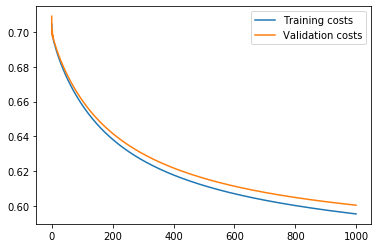

In [164]:
#Call your logistic regression class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')
lrObj = LRClass()
lrObj.train(X, Y, epochs = 1000)

#(viii) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
predict_values = lrObj.predict(testX)
accuracy = lrObj.score(testY, predict_values)
print("Accuracy of test set is: ",accuracy)


In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

X, Y = getBinaryfer13Data('fer3and4train.csv')
testX, testY = getBinaryfer13Data('fer3and4test.csv')
#X, Y = X[:-1000], Y[:-1000]

logisticRegr = LogisticRegression()
logisticRegr.fit(X, Y)
y_pred=logisticRegr.predict(testX)
score = logisticRegr.score(testX, testY)
print("Accuracy (Logistic Regression - Sklearn): ", score)

Accuracy (Logistic Regression - Sklearn):  0.683


# PART 2.1 - Neural Network (1-layer)

In [18]:
# Implement a neural network class to read in vectorized 48 x 48 images;
# so that the dimension of the input is 2304.
# The class includes function train (weight learning), forward (forward activations), 
# predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class NNClass(object):
    def __init__(self):
        self.W1 = None
        self.W2 = None
        self.b1 = 0
        self.b2 = 0
    
    def train(self, X, Y, step_size=10e-7, epochs=10):
        # Validation data set extracted from the training data
        #X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]   
        K = len(set(Y))    #number of categories
        
        # Convert outputs of the NN to an indicator matrix
        Ytrain_ind = y2indicator(Y, K)
        Yvalid_ind = y2indicator(Yvalid, K)
        M, D = X.shape
        M1 = 20

        #(i) Randomly initialize all the hidden weights W's and biases b's 
        #ADD CODE HERE...
        self.W1,self.b1 = init_weight_and_bias_NN(D, M1)
        self.W2,self.b2 = init_weight_and_bias_NN(M1, K)        

        #(ii) For the given number of epochs set, implement backpropagation to learn the
        #       weights and append computed costs in the 2 cost arrays
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        for i in range(epochs):
            #(iii) Call forward propagation twice; once to calculate P(Ytrain|X) 
            #       and Ztrain (activations at hidden layer); second to calculate P(Yvalid|Xvalid) and Zvalid
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            
            #(iv) Now we do a first round of back propagation by first performing 
            #       gradient descent using equations (3) and (4) from the HW text
            self.W2 = self.W2 - (step_size * np.dot(Z.T,(pY - Ytrain_ind)))
            self.b2 = self.b2 - (step_size * (pY - Ytrain_ind).sum())
                    
                    
            #(v) Then we propagate the errors we got from the previous layer W2 update W1 and b1
            dJ = np.multiply(np.dot((pY - Ytrain_ind),self.W2.T) , (1 - np.power(Z, 2)))
            self.W1 = self.W1 - (step_size * np.dot(X.T, dJ))
            self.b1 = self.b1 - (step_size * dJ.sum())
            
  
            #(vi) Compute the training and validation errors using cross_entropy cost
            #       function; once on the training predictions and once on validation predictions
            #       append errors to appropriate error array 
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            Ypred = self.predict(Xvalid)
            #L2_cost = (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))*(lambd/(2*len(Ytrain_ind)))
            train_costs.append(cost(Ytrain_ind, pY)/(K*len(Ytrain_ind)))
            valid_costs.append(cost(Yvalid_ind, pYvalid)/(K*len(Yvalid_ind)))
            validation_error = error_rate(Yvalid,Ypred)
            if validation_error < best_validation_error:
                best_validation_error = validation_error
        
            
        #(vii) Print out the best validation error and training and validation classification rates
        print("best_validation_error:", best_validation_error)
        print("Training classification rates:", self.classification_rate(Y, self.predict(pY)))
        print("Validation classification rates:", self.classification_rate(Yvalid, self.predict(pYvalid)))
                                  
        #(viii) Display the training and validation cost graphs 
        plt.plot(range(epochs),train_costs, label="Training costs")
        plt.plot(range(epochs),valid_costs, label="Validation costs", linewidth=5)
        plt.legend()
  

    # Implement the forward algorithm
    def forward(self, X):
        Z = sigmoid(np.dot(X, self.W1) + self.b1)
        pY = softmax(np.dot(Z, self.W2) + self.b2)
        return pY, Z

    # Implement the prediction algorithm
    def predict(self, P_Y_given_X):
        predict_values, Z_predict = self.forward(P_Y_given_X)
        try:
            pred = np.argmax(predict_values, axis=1)
        except:
            pred = np.argmax(predict_values)
        return pred
    
    # Implement a method to compute accuracy or classification rate
    def classification_rate(self, Y, P):
        acc = 0
        acc = 1 - error_rate(Y, P)
        return acc
    
    def cross_entropy(self, T, pY):
        cost = cost(T, pY)
        return cost

best_validation_error: 0.371
Accuracy of test set is : 0.6676666666666666


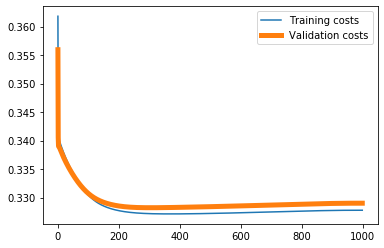

In [19]:
#Call your neural network class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')
nnObj = NNClass()
nnObj.train(X, Y, epochs = 1000)

#(ix) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
predict_values = nnObj.predict(testX)
accuracy = nnObj.classification_rate(testY, predict_values)
print("Accuracy of test set is :", accuracy)


# Part 2.2 - NN With Regularization

In [36]:
# Implement a neural network class to read in vectorized 48 x 48 images;
# so that the dimension of the input is 2304.
# The class includes function train (weight learning), forward (forward activations), 
# predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class NNClassReg(object):
    def __init__(self):
        self.W1 = None
        self.W2 = None
        self.b1 = 0
        self.b2 = 0
    
    def train(self, X, Y, step_size=10e-7, epochs=10):
        # Validation data set extracted from the training data
        #X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]   
        K = len(set(Y))    #number of categories
        
        # Convert outputs of the NN to an indicator matrix
        Ytrain_ind = y2indicator(Y, K)
        Yvalid_ind = y2indicator(Yvalid, K)
        M, D = X.shape
        M1 = 20
        lambd = 0.000001

        #(i) Randomly initialize all the hidden weights W's and biases b's 
        #ADD CODE HERE...
        self.W1,self.b1 = init_weight_and_bias_NN(D, M1)
        self.W2,self.b2 = init_weight_and_bias_NN(M1, K)        

        #(ii) For the given number of epochs set, implement backpropagation to learn the
        #       weights and append computed costs in the 2 cost arrays
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        for i in range(epochs):
            #(iii) Call forward propagation twice; once to calculate P(Ytrain|X) 
            #       and Ztrain (activations at hidden layer); second to calculate P(Yvalid|Xvalid) and Zvalid
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            
            #(iv) Now we do a first round of back propagation by first performing 
            #       gradient descent using equations (3) and (4) from the HW text
            self.W2 = self.W2 - (step_size * np.dot(Z.T,(pY - Ytrain_ind)) + ((lambd * self.W2) / len(Ytrain_ind)))
            self.b2 = self.b2 - (step_size * (pY - Ytrain_ind).sum())
                    
                    
            #(v) Then we propagate the errors we got from the previous layer W2 update W1 and b1
            dJ = np.multiply(np.dot((pY - Ytrain_ind),self.W2.T) , (1 - np.power(Z, 2)))
            self.W1 = self.W1 - (step_size * np.dot(X.T, dJ)  + ((lambd * self.W1) / len(Ytrain_ind)))
            self.b1 = self.b1 - (step_size * dJ.sum())
            
  
            #(vi) Compute the training and validation errors using cross_entropy cost
            #       function; once on the training predictions and once on validation predictions
            #       append errors to appropriate error array 
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            Ypred = self.predict(Xvalid)
            L2_cost_train = (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))*(lambd/(2*len(Ytrain_ind)))
            L2_cost_valid = (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))*(lambd/(2*len(Yvalid_ind)))
            train_costs.append((cost(Ytrain_ind, pY)/(K*len(Ytrain_ind))) + L2_cost_train)
            valid_costs.append((cost(Yvalid_ind, pYvalid)/(K*len(Yvalid_ind))) + L2_cost_valid)
            validation_error = error_rate(Yvalid,Ypred)
            if validation_error < best_validation_error:
                best_validation_error = validation_error
        
            
        #(vii) Print out the best validation error and training and validation classification rates
        print("best_validation_error:", best_validation_error)
        print("Training classification rates:", self.classification_rate(Y, self.predict(pY)))
        print("Validation classification rates:", self.classification_rate(Yvalid, self.predict(pYvalid)))
                                  
        #(viii) Display the training and validation cost graphs 
        plt.plot(range(epochs),train_costs, label="Training costs")
        plt.plot(range(epochs),valid_costs, label="Validation costs", linewidth=5)
        plt.legend()
  

    # Implement the forward algorithm
    def forward(self, X):
        Z = sigmoid(np.dot(X, self.W1) + self.b1)
        pY = softmax(np.dot(Z, self.W2) + self.b2)
        return pY, Z

    # Implement the prediction algorithm
    def predict(self, P_Y_given_X):
        predict_values, Z_predict = self.forward(P_Y_given_X)
        try:
            pred = np.argmax(predict_values, axis=1)
        except:
            pred = np.argmax(predict_values)
        return pred
    
    # Implement a method to compute accuracy or classification rate
    def classification_rate(self, Y, P):
        acc = 0
        acc = 1 - error_rate(Y, P)
        return acc
    
    def cross_entropy(self, T, pY):
        cost = cost(T, pY)
        return cost

best_validation_error: 0.389
Accuracy of test set is : 0.6493333333333333


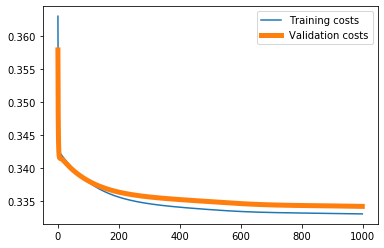

In [37]:
#Call your neural network class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')
nnObj = NNClassReg()
nnObj.train(X, Y, epochs = 1000)

#(ix) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
predict_values = nnObj.predict(testX)
accuracy = nnObj.classification_rate(testY, predict_values)
print("Accuracy of test set is :", accuracy)

# Bonus Part

In [48]:
# Implement a neural network class to read in vectorized 48 x 48 images;
# so that the dimension of the input is 2304.
# The class includes function train (weight learning), forward (forward activations), 
# predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class NNClassRelu(object):
    def __init__(self):
        self.W1 = None
        self.W2 = None
        self.b1 = 0
        self.b2 = 0
    
    def train(self, X, Y, step_size=10e-8, epochs=10):
        # Validation data set extracted from the training data
        #X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]   
        K = len(set(Y))    #number of categories
        
        # Convert outputs of the NN to an indicator matrix
        Ytrain_ind = y2indicator(Y, K)
        Yvalid_ind = y2indicator(Yvalid, K)
        M, D = X.shape
        M1 = 15

        #(i) Randomly initialize all the hidden weights W's and biases b's 
        #ADD CODE HERE...
        self.W1,self.b1 = init_weight_and_bias_NN(D, M1)
        self.W2,self.b2 = init_weight_and_bias_NN(M1, K)        

        #(ii) For the given number of epochs set, implement backpropagation to learn the
        #       weights and append computed costs in the 2 cost arrays
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        for i in range(epochs):
            #(iii) Call forward propagation twice; once to calculate P(Ytrain|X) 
            #       and Ztrain (activations at hidden layer); second to calculate P(Yvalid|Xvalid) and Zvalid
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            
            #(iv) Now we do a first round of back propagation by first performing 
            #       gradient descent using equations (3) and (4) from the HW text
            self.W2 = self.W2 - (step_size * np.dot(Z.T,(pY - Ytrain_ind)))
            self.b2 = self.b2 - (step_size * (pY - Ytrain_ind).sum())
                    
                    
            #(v) Then we propagate the errors we got from the previous layer W2 update W1 and b1
            dJ = np.multiply(np.dot((pY - Ytrain_ind),self.W2.T) , (1 - np.power(Z, 2)))
            self.W1 = self.W1 - (step_size * np.dot(X.T, dJ))
            self.b1 = self.b1 - (step_size * dJ.sum())
            
  
            #(vi) Compute the training and validation errors using cross_entropy cost
            #       function; once on the training predictions and once on validation predictions
            #       append errors to appropriate error array 
            pY, Z = self.forward(X)
            pYvalid, Zvalid = self.forward(Xvalid)
            Ypred = self.predict(Xvalid)
            #L2_cost = (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))*(lambd/(2*len(Ytrain_ind)))
            train_costs.append(cost(Ytrain_ind, pY)/(K*len(Ytrain_ind)))
            valid_costs.append(cost(Yvalid_ind, pYvalid)/(K*len(Yvalid_ind)))
            validation_error = error_rate(Yvalid,Ypred)
            if validation_error < best_validation_error:
                best_validation_error = validation_error
        
            
        #(vii) Print out the best validation error and training and validation classification rates
        print("best_validation_error:", best_validation_error)
        print("Training Costs:", self.classification_rate(Y, self.predict(X)))
        print("Validation Costs:", self.classification_rate(Yvalid, Ypred))
                                  
        #(viii) Display the training and validation cost graphs 
        plt.plot(range(epochs),train_costs, label="Training costs")
        plt.plot(range(epochs),valid_costs, label="Validation costs", linewidth=5)
        plt.legend()
  

    # Implement the forward algorithm
    def forward(self, X):
        Z = sigmoid(np.dot(X, self.W1) + self.b1)
        pY = sigmoid(np.dot(Z, self.W2) + self.b2)
        return pY, Z

    # Implement the prediction algorithm
    def predict(self, P_Y_given_X):
        predict_values, Z_predict = self.forward(P_Y_given_X)
        try:
            pred = np.argmax(predict_values, axis=1)
        except:
            pred = np.argmax(predict_values)
        return pred
    
    # Implement a method to compute accuracy or classification rate
    def classification_rate(self, Y, P):
        acc = 0
        acc = 1 - error_rate(Y, P)
        return acc
    
    def cross_entropy(self, T, pY):
        cost = cost(T, pY)
        return cost

best_validation_error: 0.512
Training Costs: 0.5125609976504608
Validation Costs: 0.486
Accuracy of test set is : 0.5860000000000001


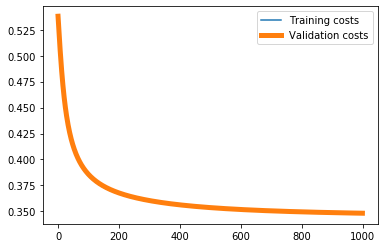

In [49]:
#Call your neural network class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')
nnObj = NNClassRelu()
nnObj.train(X, Y, epochs = 1000)

#(ix) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
predict_values = nnObj.predict(testX)
accuracy = nnObj.classification_rate(testY, predict_values)
print("Accuracy of test set is :", accuracy)

# PART 3 - SVM Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

#Train the SVM
X, Y = getBinaryfer13Data('fer3and4train.csv')
Xvalid, Yvalid = X[-1000:], Y[-1000:]
Xtrain, Ytrain = X[:-1000], Y[:-1000]
#Xtrain, Ytrain = X[:-1000], Y[:-1000]   
#ADD CODE HERE...
# (a) Linear Kernel
linear_kernel = SVC(kernel='linear')
linear_kernel.fit(Xtrain, Ytrain)
#linear_kernel.fit(Xvalid, Yvalid)

# (b) RBF kernel
rbf_kernel = SVC(kernel='rbf')
rbf_kernel.fit(Xtrain, Ytrain)
#rbf_kernel.fit(Xvalid, Yvalid)

# (c) Polynomial kernel
poly_kernel = SVC(kernel='poly', degree=3)
poly_kernel.fit(Xtrain, Ytrain)
#poly_kernel.fit(Xvalid, Yvalid)


#Test the SVM
testX, testY = getBinaryfer13Data('fer3and4test.csv')

lk_predicted = linear_kernel.predict(testX)
rk_predicted = rbf_kernel.predict(testX)
pk_predicted = poly_kernel.predict(testX)


print("-------Linear Kernel-------")
print("Accuracy:", accuracy_score(testY, lk_predicted))
print("Confusion Matrix: ", confusion_matrix(testY, lk_predicted))
print("Classification Report: ", classification_report(testY, lk_predicted))

print("-------RBF Kernel-------")
print("Accuracy:", accuracy_score(testY, rk_predicted))
print("Confusion Matrix: ", confusion_matrix(testY, rk_predicted))
print("Classification Report: ", classification_report(testY, rk_predicted))


print("-------Polynomial Kernel-------")
print("Accuracy:", accuracy_score(testY, pk_predicted))
print("Confusion Matrix: ", confusion_matrix(testY, pk_predicted))
print("Classification Report: ", classification_report(testY, pk_predicted))

#Report overall the accuracy from the results of the different SVM kernels
# print(confusion_matrix(testY, predY))
# print(classification_report(testY, predY))